# Improving induced grammars

Scripts to analyze the induced grammar.

In [87]:
import os
import json
import sys
from copy import deepcopy
import matplotlib.pyplot as plt

sys.path.append("../")
from dreamcoder.program import Primitive, Program
from dreamcoder.type import arrow, tint, t0, t1, tlist, tbool
from dreamcoder.domains.clevr.clevrPrimitives import tclevrcolor, tclevrsize, tclevrmaterial, tclevrshape, tclevrrelation, tclevrobject

In [88]:
# Some utils.

def get_primitives(program):
    """Returns the set of primitives in the program."""
    primitives = set()
    for _, subprog in program.walk():
        if isinstance(subprog, Primitive):
            primitives.add(subprog)

    return primitives

def primitive_in_program(primitive, program):
    """Returns if the primitive is in the program."""
    for _, subprog in program.walk():
        if isinstance(subprog, Primitive) and subprog == primitive:
            return True

    return False

In [89]:
domain = "list_functions"

## Induced Grammar Analysis

In [112]:
method_name = "dfl_search_collapse_compress_enum=120_n=64_remove_enum=10"
exp_name = "compression"
run_path = f"/Users/samacquaviva/Documents/projects/dfl2dsl/experiments_iterative/outputs/{exp_name}/domains/{domain}/{method_name}/seed_0/{method_name}_all"
n_iterations = int(max([f for f in os.listdir(run_path) if f.isdigit()], key=int)) + 1

In [113]:
# Load primitives + search results.
i = n_iterations - 1

grammar_f = os.path.join(run_path, str(i), "laps_grammar.json")
with open(grammar_f, "r") as f:
    grammar_log = json.load(f)
frontier_f = os.path.join(run_path, str(i), "frontiers.json")
with open(frontier_f, "r") as f:
    frontier_log = json.load(f)

In [114]:
# Load the primitives.
prim_names = list(grammar_log["definitions"].keys())
prim_names.sort()

print(f"Iteration {i}")
# Primitive.GLOBALS = {}
for prim_name in prim_names:
    # print(f"{prim_name}: {grammar_log['definitions'][prim_name]}")
    exec(grammar_log["definitions"][prim_name])


Iteration 1


In [115]:
# Parse search program strings into Program objects.
# (Removing inventions).
task_to_progs = {}
for task, task_search_info in frontier_log["train"].items():
    task_to_progs[task] = []
    for program_log in task_search_info["programs"]:
        program = program_log["program"]
        parsed_program = Program.parse(program).betaNormalForm()
        task_to_progs[task].append(parsed_program)

In [116]:
prim_to_tasks = {}  # Primitive -> tasks it appears in.
for task, progs in task_to_progs.items():
    for prog in progs:
        for prim in get_primitives(prog):
            if prim not in prim_to_tasks:
                prim_to_tasks[prim] = set()
            prim_to_tasks[prim].add(task)

In [117]:
# Check if the primitive is needed in all tasks.

prim_to_percent_needed = {}
task_to_progs_copy = deepcopy(task_to_progs)
new_prims = set()
for prim in sorted(prim_to_tasks.keys(), key=lambda p: len(prim_to_tasks[p])):

    n_tasks = len(prim_to_tasks[prim])
    n_needed = 0

    # Check if the primitive is needed.
    for task in prim_to_tasks[prim]:
        needed = True

        for prog in task_to_progs_copy[task]:
            if not primitive_in_program(prim, prog):
                needed = False
                break
        if needed:
            n_needed += 1

    prim_to_percent_needed[prim] = n_needed / n_tasks

Text(0.5, 0.98, 'dfl_search_collapse_compress_enum=120_n=64_remove_enum=10')

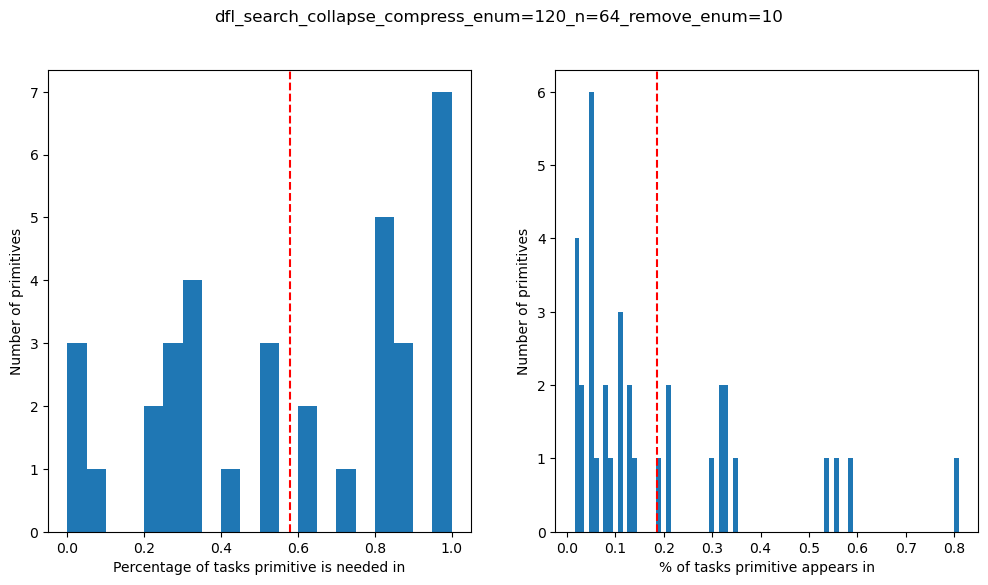

In [118]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6))

ax0.hist(prim_to_percent_needed.values(), bins=20)
ax0.set_xlabel("Percentage of tasks primitive is needed in")
ax0.set_ylabel("Number of primitives")
ax0.axvline(x=sum(prim_to_percent_needed.values()) / len(prim_to_percent_needed), color='r', linestyle='--')

n_solved_tasks = sum([1 for task in task_to_progs if len(task_to_progs[task]) > 0])
ax1.hist([len(prim_to_tasks[prim]) / n_solved_tasks for prim in prim_to_tasks], bins=80)
ax1.set_xlabel("% of tasks primitive appears in")
ax1.set_ylabel("Number of primitives")
ax1.axvline(x=sum([len(prim_to_tasks[prim]) / n_solved_tasks for prim in prim_to_tasks]) / len(prim_to_tasks), color='r', linestyle='--')

fig.suptitle(method_name)


Text(0.5, 0.98, 'dfl_search_collapse_compress_enum=120_n=64')

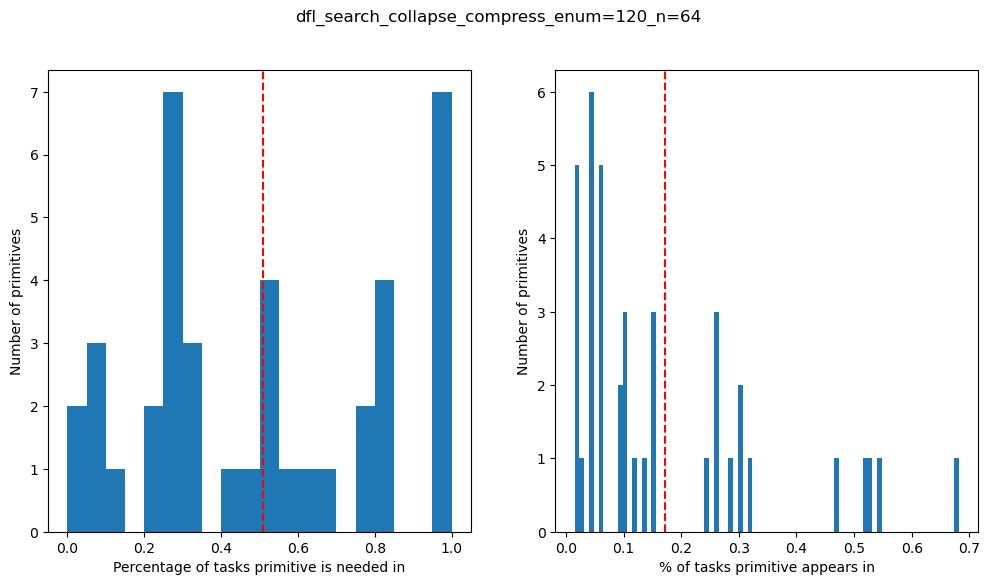

In [110]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6))

ax0.hist(prim_to_percent_needed.values(), bins=20)
ax0.set_xlabel("Percentage of tasks primitive is needed in")
ax0.set_ylabel("Number of primitives")
ax0.axvline(x=sum(prim_to_percent_needed.values()) / len(prim_to_percent_needed), color='r', linestyle='--')

n_solved_tasks = sum([1 for task in task_to_progs if len(task_to_progs[task]) > 0])
ax1.hist([len(prim_to_tasks[prim]) / n_solved_tasks for prim in prim_to_tasks], bins=80)
ax1.set_xlabel("% of tasks primitive appears in")
ax1.set_ylabel("Number of primitives")
ax1.axvline(x=sum([len(prim_to_tasks[prim]) / n_solved_tasks for prim in prim_to_tasks]) / len(prim_to_tasks), color='r', linestyle='--')

fig.suptitle(method_name)


In [119]:
for prim in sorted(prim_to_tasks.keys(), key=lambda p: len(prim_to_tasks[p])):
    print(f"{prim}: {prim_to_percent_needed[prim]} ({len(prim_to_tasks[prim])} tasks)")

foldl_c018: 0.0 (1 tasks)
rule_c068: 1.0 (1 tasks)
constant_list_c090: 1.0 (1 tasks)
rule_list_c092: 1.0 (1 tasks)
map_c072: 0.5 (2 tasks)
range_c073: 1.0 (2 tasks)
constant_list_c044: 0.3333333333333333 (3 tasks)
prefix_list_c047: 0.3333333333333333 (3 tasks)
list_9340_c069: 0.3333333333333333 (3 tasks)
cons_c096: 0.3333333333333333 (3 tasks)
<=_c053: 1.0 (3 tasks)
if_c053: 1.0 (3 tasks)
zip_with_c073: 0.25 (4 tasks)
const_list_c043: 1.0 (5 tasks)
constant_list_c091: 0.8 (5 tasks)
swap_c034: 0.8333333333333334 (6 tasks)
tail_c066: 0.2857142857142857 (7 tasks)
set_item_c067: 0.7142857142857143 (7 tasks)
reverse_c080: 0.2857142857142857 (7 tasks)
list_7291_c069: 0.5 (8 tasks)
max_c078: 0.875 (8 tasks)
98_c096: 0.2222222222222222 (9 tasks)
get_item_c048: 0.4166666666666667 (12 tasks)
sum_c079: 0.8461538461538461 (13 tasks)
concat_c092: 0.6153846153846154 (13 tasks)
-_c067: 0.631578947368421 (19 tasks)
+_c073: 0.8 (20 tasks)
slice_c053: 0.05 (20 tasks)
slice_c030: 0.047619047619047616 (21

Text(0.5, 0.98, 'dfl_search_compress_enum=120_n=64')

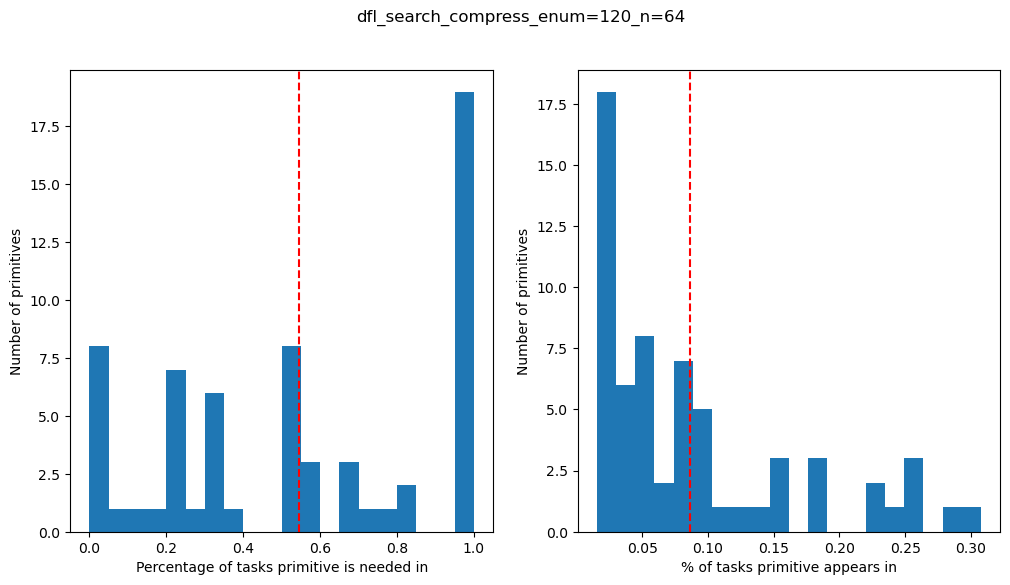

In [96]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6))

ax0.hist(prim_to_percent_needed.values(), bins=20)
ax0.set_xlabel("Percentage of tasks primitive is needed in")
ax0.set_ylabel("Number of primitives")
ax0.axvline(x=sum(prim_to_percent_needed.values()) / len(prim_to_percent_needed), color='r', linestyle='--')

n_solved_tasks = sum([1 for task in task_to_progs if len(task_to_progs[task]) > 0])
ax1.hist([len(prim_to_tasks[prim]) / n_solved_tasks for prim in prim_to_tasks], bins=20)
ax1.set_xlabel("% of tasks primitive appears in")
ax1.set_ylabel("Number of primitives")
ax1.axvline(x=sum([len(prim_to_tasks[prim]) / n_solved_tasks for prim in prim_to_tasks]) / len(prim_to_tasks), color='r', linestyle='--')

fig.suptitle(method_name)


Text(0.5, 0.98, 'dfl_search_compress_enum=120_n=1')

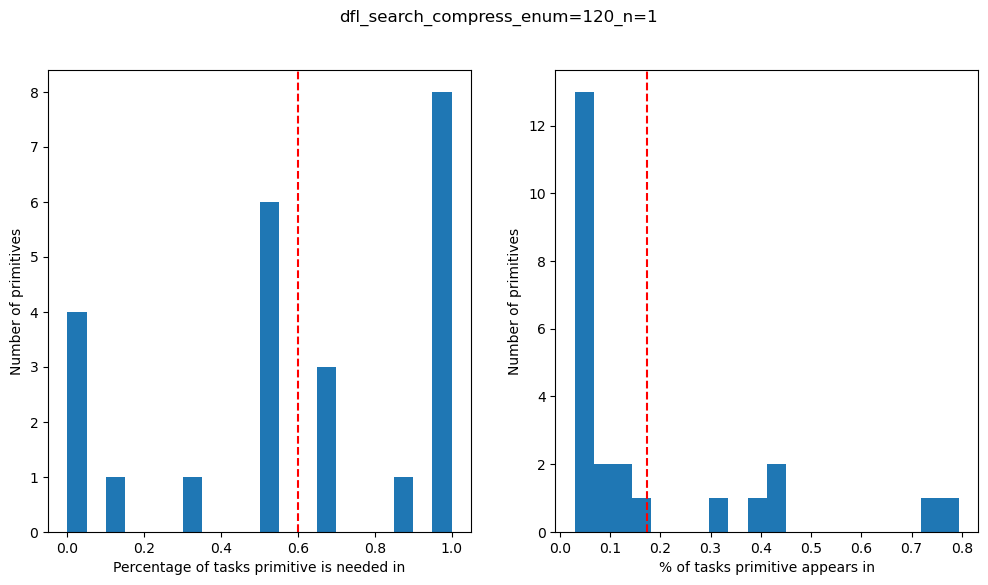

In [71]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6))

ax0.hist(prim_to_percent_needed.values(), bins=20)
ax0.set_xlabel("Percentage of tasks primitive is needed in")
ax0.set_ylabel("Number of primitives")
ax0.axvline(x=sum(prim_to_percent_needed.values()) / len(prim_to_percent_needed), color='r', linestyle='--')

n_solved_tasks = sum([1 for task in task_to_progs if len(task_to_progs[task]) > 0])
ax1.hist([len(prim_to_tasks[prim]) / n_solved_tasks for prim in prim_to_tasks], bins=20)
ax1.set_xlabel("% of tasks primitive appears in")
ax1.set_ylabel("Number of primitives")
ax1.axvline(x=sum([len(prim_to_tasks[prim]) / n_solved_tasks for prim in prim_to_tasks]) / len(prim_to_tasks), color='r', linestyle='--')

fig.suptitle(method_name)


Text(0.5, 0.98, 'dfl_search_collapse_compress_enum=120_n=1')

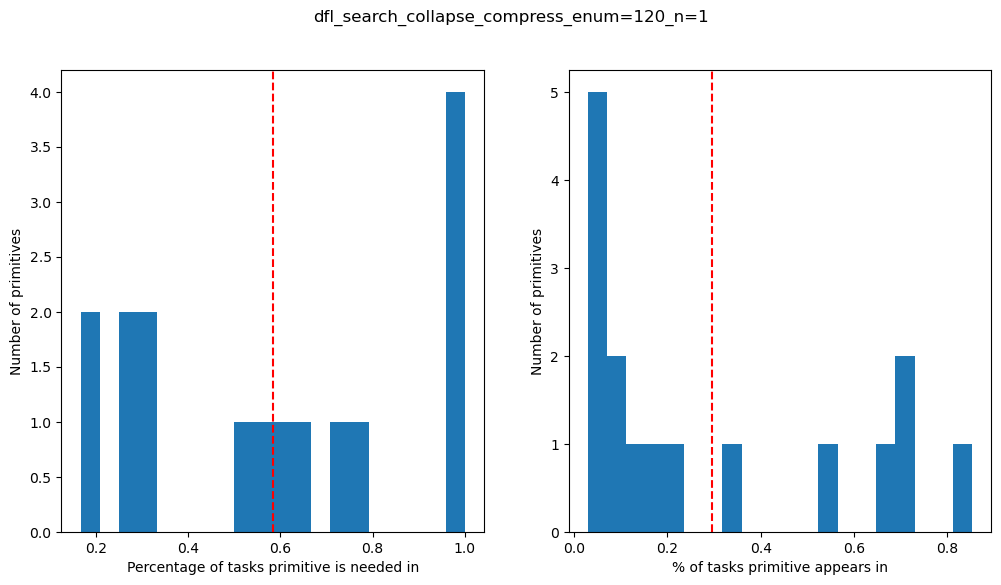

In [79]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6))

ax0.hist(prim_to_percent_needed.values(), bins=20)
ax0.set_xlabel("Percentage of tasks primitive is needed in")
ax0.set_ylabel("Number of primitives")
ax0.axvline(x=sum(prim_to_percent_needed.values()) / len(prim_to_percent_needed), color='r', linestyle='--')

n_solved_tasks = sum([1 for task in task_to_progs if len(task_to_progs[task]) > 0])
ax1.hist([len(prim_to_tasks[prim]) / n_solved_tasks for prim in prim_to_tasks], bins=20)
ax1.set_xlabel("% of tasks primitive appears in")
ax1.set_ylabel("Number of primitives")
ax1.axvline(x=sum([len(prim_to_tasks[prim]) / n_solved_tasks for prim in prim_to_tasks]) / len(prim_to_tasks), color='r', linestyle='--')

fig.suptitle(method_name)


In [201]:
# Iterate over primitives (from primitives that appear in fewest to most tasks)
# and add them to the new_prims set if there is not another program that solves
# the same task without that primitive. If the primitive is not needed (there is
# another program that solves the task without it), we remove the programs that
# contain that primitive from the task_to_progs dict.

In [120]:
a = {
        "n_previous_primitives": 64,
        "n_current_primitives": 38,
        "primitives_removed": [
            "6_c008",
            "tail_c049",
            "1_c053",
            "concat_c053",
            "0_c053",
            "2_c053",
            "get_item_c007",
            "length_c030",
            "append_c038",
            "9_c038",
            "reverse_c100",
            "3_c071",
            "4_c071",
            "5_c071",
            "7_c071",
            "8_c071",
            "repeat_c051",
            "11_c097",
            "21_c097",
            "43_c097",
            "19_c097",
            "89_c097",
            "10_c093",
            "double_c072",
            "repeat_c052",
            "head_c066"
        ],
        "primitives_kept": [
            "take_c008",
            "concat_c092",
            "rule_list_c092",
            "if_c053",
            "<=_c053",
            "length_c053",
            "slice_c053",
            "constant_list_5_2_c042",
            "int->list_c048",
            "get_item_c048",
            "sum_c079",
            "set_item_c067",
            "-_c067",
            "list2_c007",
            "slice_c030",
            "constant_list_c044",
            "map_c071",
            "rule_c068",
            "prefix_list_c047",
            "57_c097",
            "zip_with_c073",
            "+_c073",
            "range_c073",
            "append_c096",
            "cons_c096",
            "98_c096",
            "37_c096",
            "constant_list_c091",
            "constant_list_c090",
            "map_c072",
            "const_list_c043",
            "max_c078",
            "list_9340_c069",
            "list_7291_c069",
            "reverse_c080",
            "foldl_c018",
            "tail_c066",
            "swap_c034"
        ]
    }

for i in sorted(a["primitives_removed"]):
    print(i)
print()
for i in sorted(a["primitives_kept"]):
    print(i)

0_c053
10_c093
11_c097
19_c097
1_c053
21_c097
2_c053
3_c071
43_c097
4_c071
5_c071
6_c008
7_c071
89_c097
8_c071
9_c038
append_c038
concat_c053
double_c072
get_item_c007
head_c066
length_c030
repeat_c051
repeat_c052
reverse_c100
tail_c049

+_c073
-_c067
37_c096
57_c097
98_c096
<=_c053
append_c096
concat_c092
cons_c096
const_list_c043
constant_list_5_2_c042
constant_list_c044
constant_list_c090
constant_list_c091
foldl_c018
get_item_c048
if_c053
int->list_c048
length_c053
list2_c007
list_7291_c069
list_9340_c069
map_c071
map_c072
max_c078
prefix_list_c047
range_c073
reverse_c080
rule_c068
rule_list_c092
set_item_c067
slice_c030
slice_c053
sum_c079
swap_c034
tail_c066
take_c008
zip_with_c073


## DC Grammar Analysis

In [43]:
method_name = "dreamcoder_enum=120_rts=0"
run_path = f"/Users/samacquaviva/Documents/projects/dfl2dsl/experiments_iterative/outputs/baselines/domains/{domain}/{method_name}/seed_0/{method_name}_all"
n_iterations = int(max([f for f in os.listdir(run_path) if f.isdigit()], key=int)) + 1

In [44]:
# Define the primitives.
import importlib

Primitive.GLOBALS = {}
if domain == "list_functions":
    from dreamcoder.domains.list.listPrimitives import primitives as list_dsl_primitives
    list_dsl_primitives()
elif domain == "clevr":
    import dreamcoder.domains.clevr.clevrPrimitives as clevrPrimitives
    from src.models.laps_grammar import LAPSGrammar
    importlib.reload(clevrPrimitives)

    c = clevrPrimitives.load_clevr_primitives(
            ["ALL"]
        )
    # d = LAPSGrammar.uniform(a)
    # b = clevrPrimitives.clevr_original_v1_primitives()
    # _ = LAPSGrammar.uniform(b)

else:
    raise ValueError(f"Domain {domain} not recognized.")
print(Primitive.GLOBALS)

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, 'empty': empty, 'singleton': singleton, 'range': range, '++': ++, 'mapi': mapi, 'reducei': reducei, 'true': true, 'not': not, 'and': and, 'or': or, 'sort': sort, '+': +, '*': *, 'negate': negate, 'mod': mod, 'eq?': eq?, 'gt?': gt?, 'is-prime': is-prime, 'is-square': is-square, 'sum': sum, 'reverse': reverse, 'all': all, 'any': any, 'index': index, 'filter': filter, 'slice': slice}


In [45]:
# Load primitives + search results.
i = n_iterations - 1

grammar_f = os.path.join(run_path, str(i), "laps_grammar.json")
with open(grammar_f, "r") as f:
    grammar_log = json.load(f)
frontier_f = os.path.join(run_path, str(i), "frontiers.json")
with open(frontier_f, "r") as f:
    frontier_log = json.load(f)

In [46]:
# Parse search program strings into Program objects.
# (Removing inventions).
task_to_progs = {}
for task, task_search_info in frontier_log["train"].items():
    task_to_progs[task] = []
    for program_log in task_search_info["programs"]:
        program = program_log["program"]
        parsed_program = Program.parse(program).betaNormalForm()
        task_to_progs[task].append(parsed_program)

In [47]:
prim_to_tasks = {}  # Primitive -> tasks it appears in.
for task, progs in task_to_progs.items():
    for prog in progs:
        for prim in get_primitives(prog):
            if prim not in prim_to_tasks:
                prim_to_tasks[prim] = set()
            prim_to_tasks[prim].add(task)

In [48]:
# Check if the primitive is needed in all tasks.

prim_to_percent_needed = {}
task_to_progs_copy = deepcopy(task_to_progs)
new_prims = set()
for prim in sorted(prim_to_tasks.keys(), key=lambda p: len(prim_to_tasks[p])):

    n_tasks = len(prim_to_tasks[prim])
    n_needed = 0

    # Check if the primitive is needed.
    for task in prim_to_tasks[prim]:
        needed = True

        for prog in task_to_progs_copy[task]:
            if not primitive_in_program(prim, prog):
                needed = False
                break
        if needed:
            n_needed += 1

    prim_to_percent_needed[prim] = n_needed / n_tasks
    if n_needed == 0:
        print(f"{prim} is not needed in any tasks.")

empty is not needed in any tasks.
mod is not needed in any tasks.
filter is not needed in any tasks.
true is not needed in any tasks.


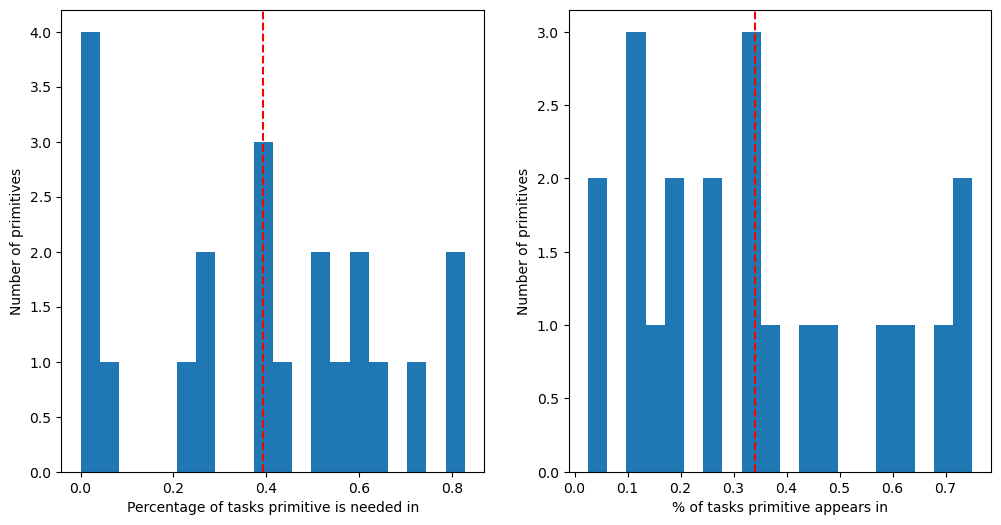

In [50]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6))

ax0.hist(prim_to_percent_needed.values(), bins=20)
ax0.set_xlabel("Percentage of tasks primitive is needed in")
ax0.set_ylabel("Number of primitives")
ax0.axvline(x=sum(prim_to_percent_needed.values()) / len(prim_to_percent_needed), color='r', linestyle='--')

n_solved_tasks = sum([1 for task in task_to_progs if len(task_to_progs[task]) > 0])
ax1.hist([len(prim_to_tasks[prim]) / n_solved_tasks for prim in prim_to_tasks], bins=20)
ax1.set_xlabel("% of tasks primitive appears in")
ax1.set_ylabel("Number of primitives")
ax1.axvline(x=sum([len(prim_to_tasks[prim]) / n_solved_tasks for prim in prim_to_tasks]) / len(prim_to_tasks), color='r', linestyle='--')
